#### Imports... `get_data()`... whatnot

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator as DataGen

import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader, Dataset
import cv2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# the DACON baseline one didn't cooperate with me for some reason, so I made my own
def get_data(train):
    data_dir = 'test/'
    if train:
        data_dir = 'train/'
    # this comprehension looks right horrible, please fix later
    img_path_list = [data_dir+x for x in os.listdir(data_dir) if os.path.isfile(data_dir + x)]
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    if train:
        label_list = []
        label_list.extend(label_df['label'])
        return img_path_list, label_list
    else:
        return img_path_list

#### FeTcH yoUr DaTa hErE

In [3]:
label_df = pd.read_csv('train.csv')

In [4]:
train_img_paths, train_labels = get_data(True)

In [5]:
test_img_paths = get_data(False)

In [6]:
train_imgs = np.array([plt.imread(train_img_path) for train_img_path in train_img_paths])

In [7]:
test_imgs = np.array([plt.imread(test_img_path) for test_img_path in test_img_paths])

### Exploratory Analysis  
Checking if all the images are same dimensions

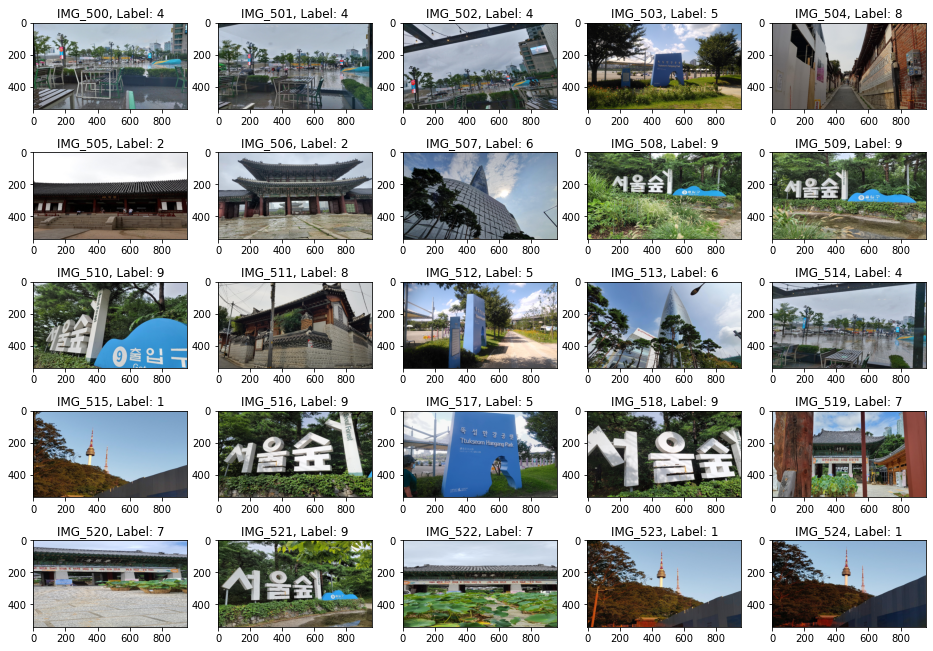

In [7]:
f, ax = plt.subplots(5,5, figsize=(16,11.5))
k = 500
ax = ax.flatten()
for i in range(25):
    ax[i].imshow(train_imgs[k+i])
    ax[i].title.set_text('IMG_' + str(k+i) + ', Label: ' + str(train_labels[k+i]))

In [8]:
train_imgs[0].shape == train_imgs[1].shape

True

In [9]:
train_imgs[0].shape

(540, 960, 3)

### What we got  
- Yes, those are the same dimensions `(540, 960, 3)`  
- Rotation seems to be apparent(also true that I saw a single rotated image through like 150), how to check for this?
  - "Rotational invariance"
  - really not the most pressing matter to deal with
- detection of augmented features

- Conclusion: Let's try other architectures as well, yes?
  - mind, the features are relatively large

## Method 1: CNN

### Data Preprocessing: Validation Split, Resizing, Datagen

#### Validation Split  
Trying the standard 75:25 split

In [8]:
train_length = len(train_imgs)

In [9]:
train_data = train_imgs[:int(train_length*0.75)]
validation_data = train_imgs[int(train_length*0.75):]

In [10]:
len(train_data), len(validation_data)

(542, 181)

In [11]:
split_train_labels = train_labels[:int(train_length*0.75)]
split_validation_labels = train_labels[int(train_length*0.75):]

In [12]:
len(split_train_labels), len(split_validation_labels)

(542, 181)

#### Resizing

Creating a `Lambda` keras layer to resize the images in batch

In [292]:
RESIZE_DIMENSION = 200
RES = (RESIZE_DIMENSION, RESIZE_DIMENSION)

In [293]:
resized = []
for train_img in train_imgs:
    resized.append(cv2.resize(train_img, RES))
resized = np.array(resized)
resized[0].shape

(200, 200, 3)

In [294]:
# original_dimension = (540, 960, 3)
# target_dimension = (128, 128, 3)

test_resized = []
for test_img in test_imgs:
    test_resized.append(cv2.resize(test_img, RES))
test_resized = np.array(test_resized)
test_resized[0].shape

(200, 200, 3)

#### Creating DataGen Object

In [295]:
def orthogonal(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

datagen = DataGen(
    preprocessing_function = orthogonal,
    rotation_range = 90,
    height_shift_range = RESIZE_DIMENSION//10,
    width_shift_range = RESIZE_DIMENSION//10,
    shear_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2)

train_datagen.fit(resized)
# train_datagen.flow(resized, train_label, batch_size=32)

##### Trying to figure out how this thing works  
and also a sanity check

In [200]:
iterator = train_datagen.flow(resized, train_labels, batch_size=25)
x_batch, y_batch = iterator.next()

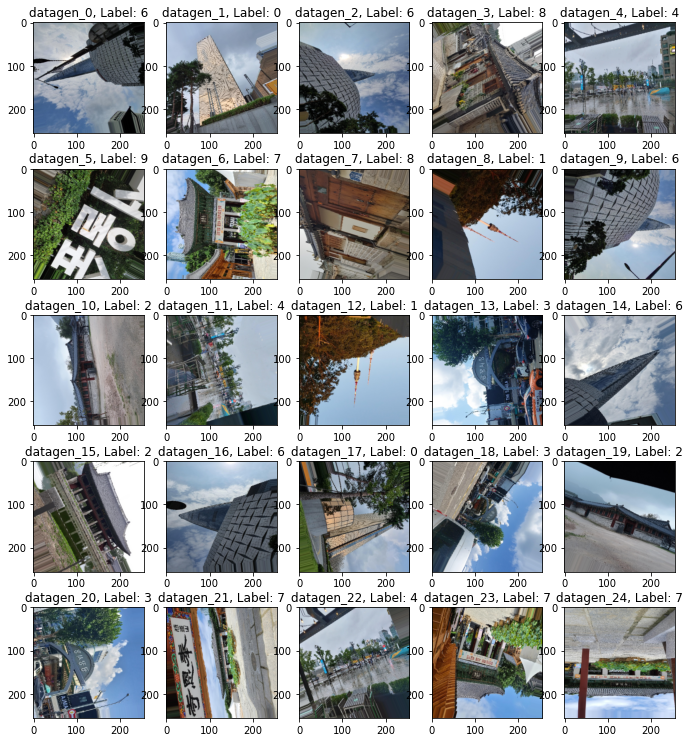

In [201]:
f, ax = plt.subplots(5,5, figsize=(11.5,13))
ax = ax.flatten()
for i in range(25):
    ax[i].imshow(x_batch[i])
    ax[i].title.set_text('datagen_' + str(i) + ', Label: ' + str(y_batch[i]))

So I think what happens is this an iterator that gets fed into the model's fit_generator method

### Building the Model

In [301]:
def cnn_build():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu),
        # tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=tf.nn.relu),
        # tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6272, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    
    return cnn_model

I am *assuming* keras needs `batch_dimension` because datagen feeds batch-by-batch???? It STILL PUT ME THROUGH A LOT OF BULLSHIT

In [302]:
cnn_model = cnn_build()
cnn_model.build(input_shape=(1,RESIZE_DIMENSION,RESIZE_DIMENSION,3))
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 200, 200, 8)          224       
_________________________________________________________________
dropout (Dropout)            (1, 200, 200, 8)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (1, 100, 100, 8)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 100, 100, 16)         1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1, 50, 50, 16)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 50, 50, 32)           4640      
_________________________________________________________________
dropout_1 (Dropout)          (1, 50, 50, 32)           0

In [303]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.9e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [304]:
tf.keras.backend.clear_session()

#### LEARN!

In [305]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = len(train_data) // BATCH_SIZE
EPOCHS = 100
VALIDATION_STEPS = len(validation_data) // BATCH_SIZE

train_generator = datagen.flow(resized, train_labels, batch_size=BATCH_SIZE, subset='training')
validation_generator = datagen.flow(resized, train_labels, batch_size=BATCH_SIZE, subset='validation')

cnn_model.fit_generator(                   train_generator,
                        steps_per_epoch  = STEPS_PER_EPOCH,
                        epochs           = EPOCHS,
                        validation_data  = validation_generator,
                        validation_steps = VALIDATION_STEPS)

Epoch 1/100
16/16 [==============================] - 4s 195ms/step - loss: 3.9988 - accuracy: 0.1014 - val_loss: 2.2843 - val_accuracy: 0.2639
Epoch 2/100
16/16 [==============================] - 3s 190ms/step - loss: 2.1648 - accuracy: 0.2402 - val_loss: 2.0063 - val_accuracy: 0.3889
Epoch 3/100
16/16 [==============================] - 3s 180ms/step - loss: 1.7614 - accuracy: 0.3602 - val_loss: 1.6135 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 3s 180ms/step - loss: 1.4464 - accuracy: 0.4886 - val_loss: 1.3586 - val_accuracy: 0.5833
Epoch 5/100
16/16 [==============================] - 3s 188ms/step - loss: 1.0982 - accuracy: 0.6035 - val_loss: 1.2022 - val_accuracy: 0.6111
Epoch 6/100
16/16 [==============================] - 3s 181ms/step - loss: 1.0253 - accuracy: 0.6335 - val_loss: 1.1361 - val_accuracy: 0.6528
Epoch 7/100
16/16 [==============================] - 3s 180ms/step - loss: 0.9866 - accuracy: 0.6460 - val_loss: 1.0489 - val_accuracy: 0.6597

### Conclusion - CNN.

In [306]:
predictions = cnn_model.predict(test_resized)

In [307]:
final = []
for prediction in predictions:
    prediction = list(prediction)
    final.append(prediction.index(max(prediction)))

In [308]:
min(final), max(final)

(0, 9)

In [309]:
final[:5]

[0, 1, 0, 0, 6]

In [310]:
submission_cnn = pd.read_csv('sample_submission.csv')
submission_cnn['label'] = final

In [311]:
SAVENAME = 'submission_cnn_08081811'
cnn_model.save(f'submission/{SAVENAME}.h5')
submission_cnn.to_csv(f'submission/{SAVENAME}.csv', index=False)

### VGG16 Architecture.

In [13]:
RESIZE_DIMENSION_VGG = 224
RES_VGG = (RESIZE_DIMENSION_VGG, RESIZE_DIMENSION_VGG)

In [14]:
resized = []
for train_img in train_imgs:
    resized.append(cv2.resize(train_img, RES_VGG))
resized = np.array(resized)
resized[0].shape

(224, 224, 3)

In [15]:
# original_dimension = (540, 960, 3)
# target_dimension = (128, 128, 3)

test_resized = []
for test_img in test_imgs:
    test_resized.append(cv2.resize(test_img, RES_VGG))
test_resized = np.array(test_resized)
test_resized[0].shape

(224, 224, 3)

#### Creating DataGen Object

In [62]:
def orthogonal(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

datagen = DataGen(
    preprocessing_function = orthogonal,
    rotation_range = 90,
    height_shift_range = RESIZE_DIMENSION_VGG//10,
    width_shift_range = RESIZE_DIMENSION_VGG//10,
    shear_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2)

datagen.fit(resized)
# train_datagen.flow(resized, train_label, batch_size=32)

In [63]:
def vgg_build():
    return tf.keras.applications.vgg16.VGG16(weights=None)

In [64]:
vgg_model = vgg_build()
vgg_model.build(input_shape=(1,RESIZE_DIMENSION_VGG,RESIZE_DIMENSION_VGG,3))
print(vgg_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [65]:
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.3e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [66]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = len(train_data) // BATCH_SIZE
EPOCHS = 100
VALIDATION_STEPS = len(validation_data) // BATCH_SIZE

train_generator = datagen.flow(resized, train_labels, batch_size=BATCH_SIZE, subset='training')
validation_generator = datagen.flow(resized, train_labels, batch_size=BATCH_SIZE, subset='validation')

vgg_model.fit_generator(                   train_generator,
                        steps_per_epoch  = STEPS_PER_EPOCH,
                        epochs           = EPOCHS,
                        validation_data  = validation_generator,
                        validation_steps = VALIDATION_STEPS)

Epoch 1/100
16/16 [==============================] - 6s 315ms/step - loss: 3.9786 - accuracy: 0.1077 - val_loss: 2.5801 - val_accuracy: 0.0833
Epoch 2/100
16/16 [==============================] - 5s 309ms/step - loss: 2.5784 - accuracy: 0.0879 - val_loss: 2.3880 - val_accuracy: 0.0833
Epoch 3/100
16/16 [==============================] - 5s 309ms/step - loss: 2.3752 - accuracy: 0.0918 - val_loss: 2.4169 - val_accuracy: 0.0833
Epoch 4/100
16/16 [==============================] - 5s 304ms/step - loss: 2.3787 - accuracy: 0.1118 - val_loss: 2.4122 - val_accuracy: 0.1667
Epoch 5/100
16/16 [==============================] - 5s 304ms/step - loss: 2.3930 - accuracy: 0.1014 - val_loss: 2.3680 - val_accuracy: 0.0556
Epoch 6/100
16/16 [==============================] - 5s 305ms/step - loss: 2.3857 - accuracy: 0.0952 - val_loss: 2.5294 - val_accuracy: 0.0833
Epoch 7/100
16/16 [==============================] - 5s 309ms/step - loss: 2.3655 - accuracy: 0.0977 - val_loss: 2.3423 - val_accuracy: 0.0764

In [69]:
predictions = vgg_model.predict(test_resized)
final = []
for prediction in predictions:
    prediction = list(prediction)
    final.append(prediction.index(max(prediction)))
    
submission_vgg = pd.read_csv('sample_submission.csv')
submission_vgg['label'] = final

SAVENAME = 'submission_vgg_08082020'
vgg_model.save(f'submission/{SAVENAME}.h5')
submission_vgg.to_csv(f'submission/{SAVENAME}.csv', index=False)

## ConvNeXt, EfficientNet, VGG16 With PyTorch  
Mostly because config looks easier than keras